In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import pickle
import xgboost
import lightgbm as lgb

from sklearn import linear_model
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.metrics import explained_variance_score, mean_absolute_error
import matplotlib.pyplot as plt

%matplotlib inline

# load data

In [2]:
df_properties_2016 = pd.read_csv('../data/properties_2016.csv')

/Users/dai_li/Workspace/VirtualEnv/competition/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_properties_2017 = pd.read_csv('../data/properties_2017.csv')

/Users/dai_li/Workspace/VirtualEnv/competition/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_transactions_2016 = pd.read_csv('../data/train_2016_v2.csv', parse_dates=['transactiondate'])
df_transactions_2017 = pd.read_csv('../data/train_2017.csv', parse_dates=['transactiondate'])

In [4]:
# use 2016 data only
df_properties = df_properties_2016
df_transactions = df_transactions_2016

In [6]:
# use 2017 data as well
df_properties = df_properties_2017
df_transactions = pd.concat((df_transactions_2016, df_transactions_2017), axis = 0)

In [7]:
df = pd.merge(left=df_properties, right=df_transactions, on='parcelid', how= 'left')

# Pre-process data

## define fields

In [ ]:
# lets make this assumption -- all the features are generated per monthly basis
# lets assume we can use future information - use the log error to generate some features

## categorical features

In [8]:
# add censustract
t = pd.DataFrame(df['rawcensustractandblock'].astype(str).str.split('.',1).tolist(),columns = ['censustrack','censusblock'])
df['censustrack'] = t['censustrack']

t = pd.DataFrame(df_properties['rawcensustractandblock'].astype(str).str.split('.',1).tolist(),columns = ['censustrack','censusblock'])
df_properties['censustrack'] = t['censustrack']


In [9]:
###################################
####### DIMENSION: SPACE ##########
###################################

parcel_location_variables = ['regionidneighborhood','regionidzip', 'regionidcity', 'censustrack','rawcensustractandblock']

# iterate through all above regions
for region in parcel_location_variables:
    
    #### COUNT OF PROPERTIES ####
    # number of properties in the zipcode
    df['f_num_n_prop_in_'+region] = df[region].map(df_properties[region].value_counts().to_dict())
    
    ##### HOW NEW IS THIS BUILDING COMPARING TO OTHER BUILDINGS #####
    df['f_cat_median_year_in_'+region] = df[region].map(df_properties.groupby(region)['yearbuilt'].aggregate('median').to_dict())
    df['f_num_how_new_in_'+region] = df['yearbuilt'] - df['f_cat_median_year_in_'+region]

    # Neighborhood latitude and longitude
    df['f_num_median_lat_in_'+region] = df[region].map(df_properties.groupby(region)['latitude'].aggregate('median').to_dict())
    df['f_num_median_lon_in_'+region] = df[region].map(df_properties.groupby(region)['longitude'].aggregate('median').to_dict())

    #### TRANSACTION RELATED ####
    # how many transaction made in this region per observed properties
    # this tells us how active a region is
    df['f_num_pct_trans_in_'+region] = df.groupby(region)['logerror'].aggregate('count') * 1.0 / df['f_num_n_prop_in_'+region] 

    #### LOG ERROR RELATED ####
    df['f_num_error_std_in_'+region] = df[region].map(df[df.transactiondate < '2016-10-01'].groupby(region)['logerror'].aggregate("std").to_dict())
    df['f_num_error_mean_in_'+region] = df[region].map(df[df.transactiondate < '2016-10-01'].groupby(region)['logerror'].aggregate("mean").to_dict())
    
    

In [10]:
###################################
####### DIMENSION: TIME ###########
###################################

time_windows = [30,60,90,180]

for time_window in time_windows:
    #### TRANSACTION RELATED FEATURES #####
    # I assume in the actual model supply/demand should also be used
    # now I will try to use historical transaction data to mimic demand
    # what is this value comparing to past few months?
    
    #### LOG ERROR RELATED FEATURES ####
    # what is the corresponding logerror rate?
    
    #### LOGERROR RATE FOR CATEGORICAL VARIABLES #####
    # assumption is that model error should persist for same type of properties # 
    # now this is tricky - logerror is not taken into consideration in the actual model
    # so this may end up being useless
    # but probably worth confirming. we will see
    const_numerator = 5
    const_denominator = 5

    #### LOGERROR RATE FOR CONTINUOUS VARIABLE BINS #####
    # assump is that model error should persist for the same type of properties # 
    # same to above #
    
    # ***** generate absolute and relative error for each month **** ### 
    
    
    ### generate seasonality features ####
    # day of week
    # week of month
    # quarter of year (only for 2017)


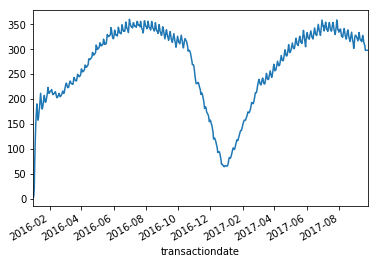

In [11]:
df.groupby('transactiondate')['transactiondate'].aggregate('count').rolling(window = 60,min_periods=0).mean().plot()

In [ ]:
#### LOG ERROR RELATED TERMS ####


In [ ]:
###################################
#######  ###########
###################################
  

# save the cleaned data

In [ ]:
#2016 data only
# df.to_csv('../tmp/processed_df_2016.csv', index=False, header=True)

In [12]:
df.to_csv('../tmp/processed_df_2017.csv', index=False, header=True)

In [159]:
# pickle.dump(df, open('../tmp/processed_df_2016.pkl', 'w'))

# process data and generate features

In [13]:
all_fields = set(df.columns)

# these are fields that are used to identify fields
identifiers = set(['transactiondate', 'parcelid'])

# log error that we want to model
label = set(['logerror'])

# the following are categorical features
feats_objects = set(
 ['taxdelinquencyflag',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'fireplaceflag',
 'hashottuborspa']
)

# the following are numerical features that should be treated as categorical features
feats_numeric_to_categorical = set([
    'airconditioningtypeid',
    'architecturalstyletypeid',
    'buildingqualitytypeid',
    'buildingclasstypeid',
    'decktypeid',
    'fips',
    'heatingorsystemtypeid',
    'propertylandusetypeid',
    'regionidcounty',
    'regionidcity',
    'regionidzip',
    'regionidneighborhood',
    'storytypeid',
    'typeconstructiontypeid',
    'yearbuilt',
    'assessmentyear',
    'taxdelinquencyyear'
])


# the rest are numeric features
feats_numeric = set([
    'basementsqft',
    'bathroomcnt',
    'bedroomcnt',
    'calculatedbathnbr',
    'threequarterbathnbr',
    'finishedfloor1squarefeet',
    'calculatedfinishedsquarefeet',
    'finishedsquarefeet6',
    'finishedsquarefeet12',
    'finishedsquarefeet13',
    'finishedsquarefeet15',
    'finishedsquarefeet50',
    'fireplacecnt',
    'fullbathcnt',
    'garagecarcnt',
    'garagetotalsqft',
    'hashottuborspa',
    'lotsizesquarefeet',
    'numberofstories',
    'poolcnt',
    'poolsizesum',
    'pooltypeid10',
    'pooltypeid2',
    'pooltypeid7',
    'roomcnt',
    'unitcnt',
    'yardbuildingsqft17',
    'yardbuildingsqft26',
    'taxvaluedollarcnt',
    'structuretaxvaluedollarcnt',
    'landtaxvaluedollarcnt',
    'taxamount'
])

feats_numerics_feature_engineered = set([col for col in df.columns if 'f_num' in col])


feats_categorical_feature_engineered = set([col for col in df.columns if 'f_cat' in col])


# fields that are thrown away for now
feats_for_consideration_later = set([
    'latitude',
    'longitude',
    'rawcensustractandblock',
    'censustractandblock',
])

In [14]:
feats_categorical = feats_numeric_to_categorical | feats_objects | feats_categorical_feature_engineered
feats_numeric = feats_numeric | feats_numerics_feature_engineered 
feats = feats_categorical | feats_numeric 

feats_categorical = list(feats_categorical)
feats_numeric = list(feats_numeric)
feats = list(feats)

# save results to pick files

In [15]:
pickle.dump(feats_categorical, open('../tmp/feats_categorical.pkl', 'w'))
pickle.dump(feats_numeric, open('../tmp/feats_numeric.pkl', 'w'))
pickle.dump(feats, open('../tmp/feats.pkl', 'w'))

In [16]:
mask_train = (df.transactiondate < '2018-10-01')
mask_validation = (df.transactiondate >= '2017-08-01')
mask_prediction = ~df.parcelid.isnull()

In [17]:
pickle.dump(mask_train, open('../tmp/mask_train.pkl', 'w'))
pickle.dump(mask_validation, open('../tmp/mask_validation.pkl', 'w'))
pickle.dump(mask_prediction, open('../tmp/mask_prediction.pkl', 'w'))